In [27]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import least, greatest, col, expr, concat_ws, when
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import tomli
import json

In [2]:
spark = SparkSession.builder \
    .appName("PokerHandParser") \
    .master("local[*]") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/06 12:19:53 WARN Utils: Your hostname, Jaceks-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.18.189 instead (on interface en0)
25/07/06 12:19:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/06 12:19:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [42]:
df_files = spark.read.json("parsed_dir")
df_files.show()

25/07/06 15:41:02 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


+--------+---------+----------------+----------------+-------+---------+-----------+-----------+---------+--------+
|card_gap|high_card|hole_card_1_rank|hole_card_2_rank|is_pair|is_suited|net_gain_bb|num_players|player_id|position|
+--------+---------+----------------+----------------+-------+---------+-----------+-----------+---------+--------+
|       1|       14|              13|              14|  false|    false|     -100.0|          6| Pluribus|       1|
|       3|       13|              10|              13|  false|    false|     -12.02|          6| MrOrange|       1|
|       1|       13|              12|              13|  false|    false|     -21.77|          6| MrOrange|       4|
|       2|       14|              12|              14|  false|    false|     -27.25|          6| MrBlonde|       0|
|       1|       14|              14|              13|  false|    false|     -100.0|          6| MrOrange|       1|
|       3|       13|              13|              10|  false|    false|

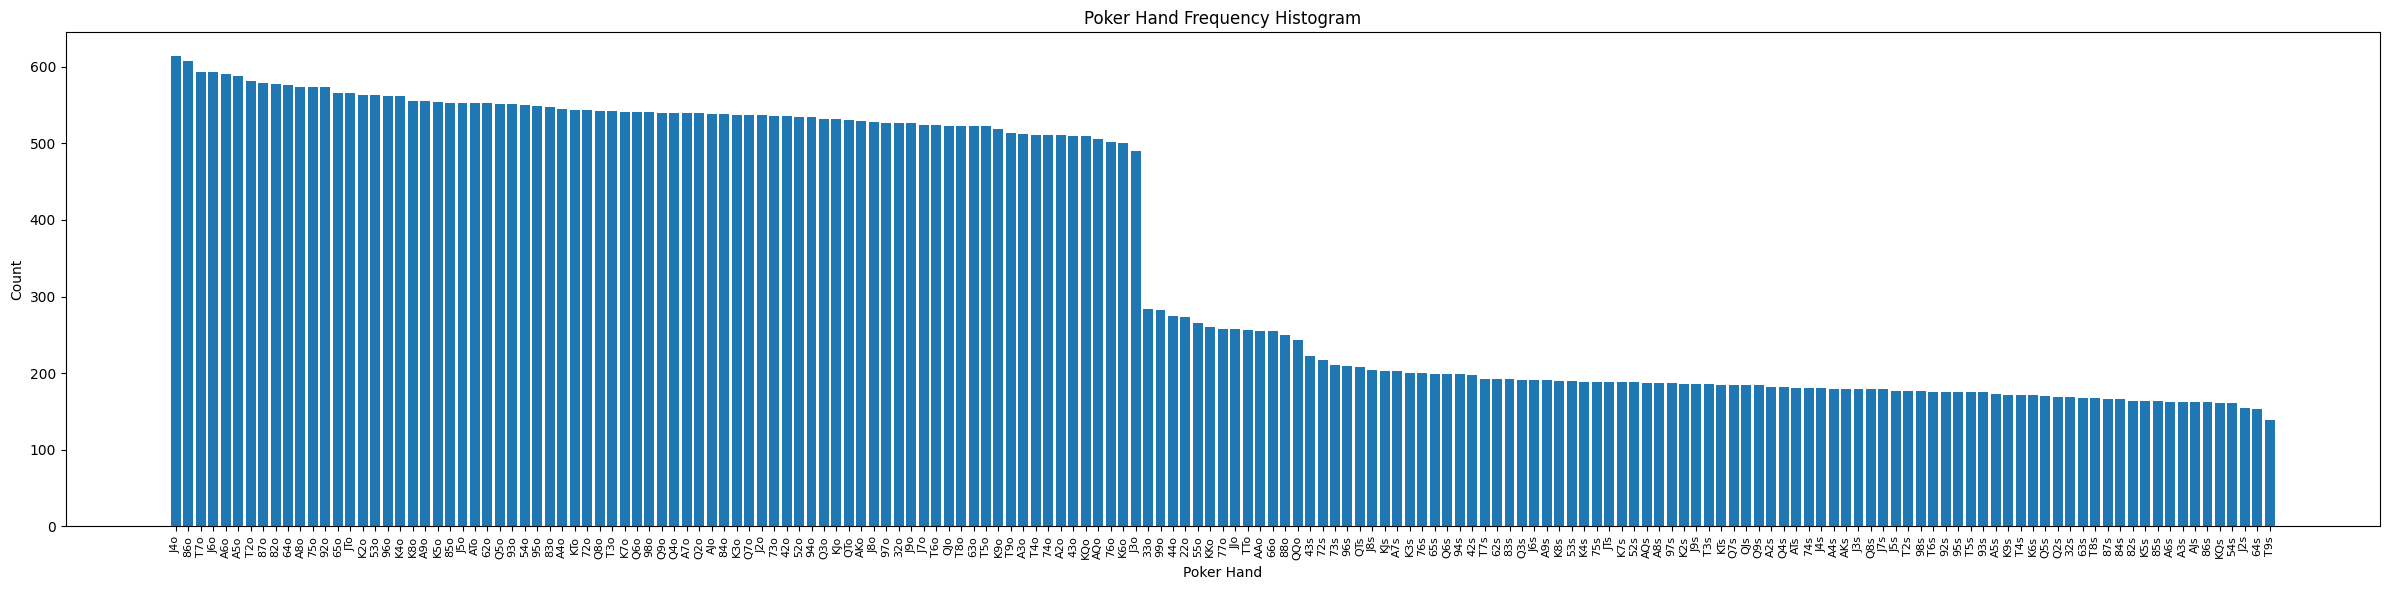

In [45]:
#new
# Step 1: Normalize ranks (regardless of card order)
df_normalized = df_files.withColumn("low_rank", least("hole_card_1_rank", "hole_card_2_rank")) \
                        .withColumn("high_rank", greatest("hole_card_1_rank", "hole_card_2_rank"))

# Step 2: Map numeric ranks to poker symbols (2–9, T, J, Q, K, A)
def rank_to_symbol(col_name):
    return when(col(col_name) == 14, "A") \
        .when(col(col_name) == 13, "K") \
        .when(col(col_name) == 12, "Q") \
        .when(col(col_name) == 11, "J") \
        .when(col(col_name) == 10, "T") \
        .otherwise(col(col_name).cast("string"))

# Step 3: Apply rank symbol conversion
df_mapped = df_normalized.withColumn("high_rank_str", rank_to_symbol("high_rank")) \
                         .withColumn("low_rank_str", rank_to_symbol("low_rank"))

# Step 4: Create hand label like "AKs" or "JTo"
df_labeled = df_mapped.withColumn(
    "hand_label",
    concat_ws(
        "",
        col("high_rank_str"),
        col("low_rank_str"),
        when(col("is_suited"), "s").otherwise("o")
    )
)

# Step 5: Group by hand_label and count
df_histogram = df_labeled.groupBy("hand_label").count().orderBy("count", ascending=False)

# Step 6: Convert to Pandas for plotting
hist_data = df_histogram.toPandas()

# Step 7: Plot clean histogram using only string labels
plt.figure(figsize=(24, 6))
plt.bar(x=hist_data['hand_label'], height=hist_data['count'])

plt.xlabel('Poker Hand')
plt.ylabel('Count')
plt.title('Poker Hand Frequency Histogram')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()